# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.501318,True,5.239554
1,0.225035,True,5.898899
2,1.104051,False,0.290492
3,0.394560,False,0.239665
4,0.103426,False,-0.213129
...,...,...,...
995,1.465602,False,0.523078
996,-1.748875,False,-1.043548
997,-0.858337,False,-0.929376
998,0.964788,False,-0.550164


<AxesSubplot: xlabel='v0'>

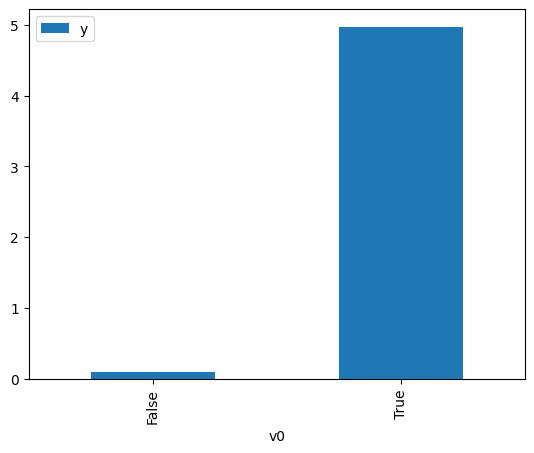

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

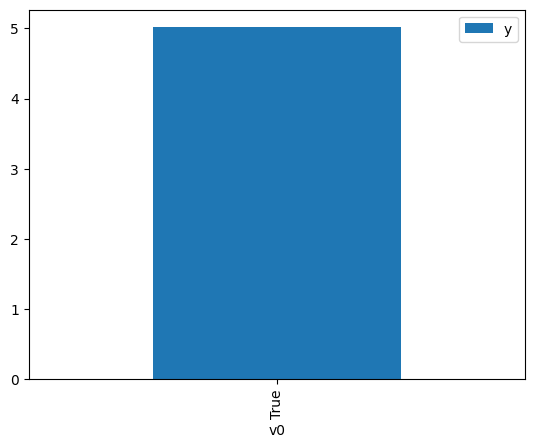

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.506776,False,-1.974882,0.494821,2.020935
1,0.506776,False,-1.974882,0.494821,2.020935
2,-0.088124,False,0.227674,0.517415,1.932685
3,0.724955,False,1.216840,0.486535,2.055353
4,-0.422175,False,-0.476498,0.530077,1.886519
...,...,...,...,...,...
995,-1.273540,False,1.385775,0.562136,1.778930
996,-1.859840,False,-0.349501,0.583931,1.712530
997,-1.225802,False,2.061799,0.560349,1.784601
998,0.807053,False,0.007252,0.483418,2.068602


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.260607,True,4.048441,0.495827,2.016832
1,0.035172,True,5.524042,0.487265,2.052271
2,1.629947,True,8.213885,0.547706,1.825798
3,-1.295408,True,5.351842,0.437046,2.288086
4,1.227022,True,4.049410,0.532497,1.877943
...,...,...,...,...,...
995,0.614450,True,4.181939,0.509269,1.963598
996,1.345595,True,3.972045,0.536981,1.862265
997,0.030155,True,4.084837,0.487075,2.053074
998,-1.838236,True,4.053511,0.416866,2.398850


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              5516.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):                        0.00
Time:                        00:44:33   Log-Likelihood:                         -1457.6
No. Observations:                1000   AIC:                                      2919.
Df Residuals:                     998   BIC:                                      2929.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1524      0.032      4.757      0.000       0.090       0.215
x2             5.0041      0.048    105.000      0.000       4.911       5.098
==============================================================================
Omnibus:                        0.998   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                0.865
Skew:                           0.045   Prob(JB):                        0.649
Kurtosis:                       3.112   Cond. No.                         1.50
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""